<a href="https://colab.research.google.com/github/2019ht12169/Thesis/blob/main/simpleBertImpl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

In [ ]:
! python3.7 -m pip install tensorflow-gpu==1.15.0
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
import matplotlib.pyplot as plt 

In [3]:
import seaborn as sns

In [4]:
# check out what the data looks like before you get started
# look at the training data set
train_df = pd.read_csv('/content/gdrive/MyDrive/projects/data/dataFile_latest_train.csv',index_col=None)
train_df=train_df.drop(['review_date'],axis='columns')
train_df = train_df.dropna().reset_index(drop=True)

# look at the test data set
test_df = pd.read_csv('/content/gdrive/MyDrive/projects/data/dataFile_latest_test.csv',index_col=None)
test_df = test_df.dropna().reset_index(drop=True)

In [ ]:
train_df['label'].astype(int)
test_df['label'].astype(int)

In [ ]:
# Print the Distribution of Labels
sns.set_theme(style="whitegrid")
ax = train_df['label'].value_counts(sort=False).plot(kind='barh', color='b')
ax.set_xlabel('Count')
ax.set_ylabel('Labels')

In [7]:
bert_df = pd.DataFrame({
    'id': range(len(train_df)),
    'label': train_df['label'],
    'alpha': ['q']*train_df.shape[0],
    'text': train_df['text'].replace(r'\n', ' ', regex=True)
})

train_bert_df, dev_bert_df = train_test_split(bert_df, test_size=0.2)

In [8]:
print(len(train_bert_df))
print(len(dev_bert_df))

992095
248024


In [9]:
test_bert_df = pd.DataFrame({
    'id': range(len(test_df)),
    'text': test_df['text'].replace(r'\n', ' ', regex=True),
    'review_date': test_df['review_date']
})

In [10]:
train_bert_df.to_csv('/content/gdrive/MyDrive/projects/data/Data-BERT/train.tsv', sep='\t', index=False, header=False)
dev_bert_df.to_csv('/content/gdrive/MyDrive/projects/data/Data-BERT/dev.tsv', sep='\t', index=False, header=False)
test_bert_df.to_csv('/content/gdrive/MyDrive/projects/data/Data-BERT/test.tsv', sep='\t', index=False, header=True)

In [ ]:
! python /content/gdrive/MyDrive/projects/bert/run_classifier.py --task_name=cola --do_train=true --do_eval=true --data_dir=/content/gdrive/MyDrive/projects/data/Data-BERT/v2 --vocab_file=/content/gdrive/MyDrive/projects/uncased_L-12_H-768_A-12/vocab.txt --bert_config_file=/content/gdrive/MyDrive/projects/uncased_L-12_H-768_A-12/bert_config.json --init_checkpoint=/content/gdrive/MyDrive/projects/uncased_L-12_H-768_A-12/bert_model.ckpt.index --max_seq_length=256 --train_batch_size=32 --learning_rate=2e-5 --num_train_epochs=3.0 --output_dir=/content/gdrive/MyDrive/projects/data/Data-BERT/v2/model_output --do_lower_case=true

In [ ]:
!python /content/gdrive/MyDrive/projects/bert/run_classifier.py --task_name=cola --do_predict=true --data_dir=/content/gdrive/MyDrive/projects/data/Data-BERT/ --vocab_file=/content/gdrive/MyDrive/projects/uncased_L-12_H-768_A-12/vocab.txt --bert_config_file=/content/gdrive/MyDrive/projects/uncased_L-12_H-768_A-12/bert_config.json --init_checkpoint=/content/gdrive/MyDrive/projects/model_output_latest/model.ckpt-43736 --max_seq_length=128 --output_dir=/content/gdrive/MyDrive/projects/data/Data-BERT/model_output_latest/

In [11]:
#read the original test data for the text and id
df_test = pd.read_csv('/content/gdrive/MyDrive/projects/data/Data-BERT/test.tsv', sep='\t',index_col=None)

#read the results data for the probabilities
df_result = pd.read_csv('/content/gdrive/MyDrive/projects/data/Data-BERT/model_output_latest/test_results.tsv', sep='\t',names=['neg', 'pos'])


In [ ]:
test_df.loc[test_df['label'] == 1, 'actual_label'] = 'pos'
test_df.loc[test_df['label'] == 0, 'actual_label'] = 'neg'

#create a new dataframe
df_map_result = pd.DataFrame({
    'pred_label': df_result.idxmax(axis=1),
    'actual_label': test_df['actual_label'],
    'review_date': df_test['review_date'],
    'text': df_test['text']})

#view sample rows of the newly created dataframe
df_map_result.to_csv('/content/gdrive/MyDrive/projects/data/Data-BERT/mapped_results.csv',header=True,index=False)
df_map_result.head()

In [12]:
def evaluate_results(mapped_df):
    y_true = mapped_df['actual_label']
    y_pred = mapped_df['pred_label']
    target_names = ['pos','neg']

    # Print the Confusion Matrix
    results_log = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)
    results_df_log = pd.DataFrame(results_log).transpose()
    print(results_df_log)
    matrix = confusion_matrix(y_true,  y_pred)
    sns.heatmap(pd.DataFrame(matrix), 
                annot=True, fmt="d", linewidths=.5, cmap="YlGnBu")
    plt.xlabel('Predictions')
    plt.xlabel('Actual')
    
    model_score = score(y_pred, y_true, average='macro')
    return model_score

              precision    recall  f1-score        support
pos            0.982061  0.750839  0.851024  155012.000000
neg            0.798354  0.986288  0.882426  155042.000000
accuracy       0.868575  0.868575  0.868575       0.868575
macro avg      0.890208  0.868563  0.866725  310054.000000
weighted avg   0.890199  0.868575  0.866726  310054.000000


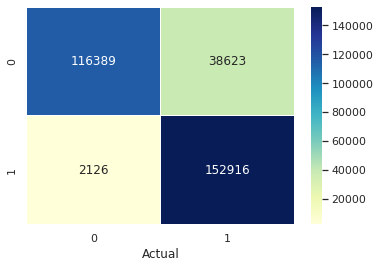

In [13]:
df_map_res = pd.read_csv('/content/gdrive/MyDrive/projects/data/Data-BERT/mapped_results.csv')
model_score = evaluate_results(df_map_res)
performance_df = pd.DataFrame().append({'model_name': 'BERT classifier', 
                                    'f1_score': model_score[0], 
                                    'precision': model_score[1], 
                                    'recall': model_score[2]}, ignore_index=True)

   f1_score       model_name  precision    recall
0  0.868563  BERT classifier   0.890208  0.866725


Text(0.5, 1.0, 'Model Outlier Detection Performance (Macro)')

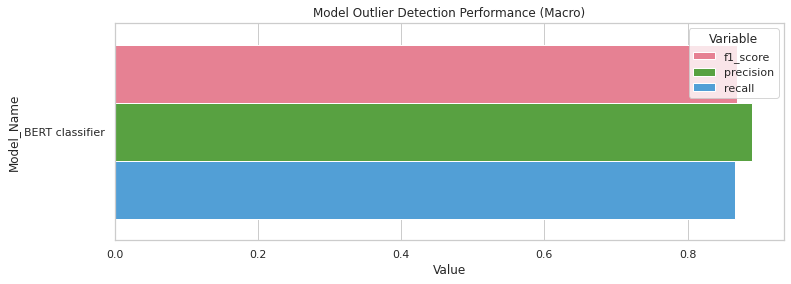

In [14]:
print(performance_df)

fig, ax = plt.subplots(figsize=(12, 4))
tidy = performance_df.melt(id_vars='model_name').rename(columns=str.title)
sns.barplot(y='Model_Name', x='Value', hue='Variable', data=tidy, ax=ax, palette='husl',  linewidth=1, edgecolor="w")
plt.title('Model Outlier Detection Performance (Macro)')

In [19]:
# grouping for data visualization [grouping by label]
score = df_map_result['text'].groupby(df_map_result['pred_label'])
score.count()

pred_label
neg     99655
pos    210399
Name: text, dtype: int64

In [20]:
# grouping for data visualization [grouping by review date's year]
df_map_result['review_date'] = pd.to_datetime(df_map_result['review_date'])
score1 = df_map_result['text'].groupby(df_map_result['review_date'].dt.strftime('%Y'))
score1.count()

review_date
1999       43
2000      445
2001      623
2002      842
2003     1105
2004     1468
2005     2264
2006     3259
2007     6214
2008     7284
2009     9457
2010    12985
2011    19533
2012    27512
2013    55523
2014    82481
2015    79016
Name: text, dtype: int64